In [1]:
# Importing libraries and packages
import geopandas as gpd
import pandas as pd
import numpy as np
import json

# Visualization
import matplotlib.pyplot as plt

# Modeling
# Installing xgboost: conda install -c conda-forge xgboost
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# Metrics
from sklearn import metrics

# Feature importance visulization
import shap
from xgboost import plot_importance

# Save models
import pickle

### Load the training Dataset (FL/TX)

In [2]:
femaTrainData = pd.read_csv('../data/open-fema/FEMA-Large-Demographics-FL-TX.csv')
print('There are {} records combined.'.format(len(femaTrainData)))

Columns (29,30,31) have mixed types.Specify dtype option on import or set low_memory=False.


There are 3533663 records combined.


In [3]:
femaTrainData.columns

Index(['disasterNumber', 'damagedCity', 'damagedStateAbbreviation',
       'damagedZipCode', 'householdComposition', 'grossIncome', 'specialNeeds',
       'homeOwnersInsurance', 'floodInsurance', 'inspected', 'rpfvl',
       'habitabilityRepairsRequired', 'destroyed', 'waterLevel', 'floodDamage',
       'foundationDamage', 'foundationDamageAmount', 'roofDamage',
       'roofDamageAmount', 'tsaEligible', 'tsaCheckedIn',
       'rentalAssistanceEligible', 'rentalAssistanceAmount',
       'repairAssistanceEligible', 'repairAmount',
       'replacementAssistanceEligible', 'replacementAmount', 'sbaEligible',
       'renterDamageLevel', 'rentalAssistanceEndDate', 'rentalResourceCity',
       'rentalResourceStateAbbreviation', 'rentalResourceZipCode',
       'primaryResidence', 'personalPropertyEligible', 'ppfvl',
       'censusBlockId', 'censusYear', 'id', 'censusTractId', 'censusid',
       'tractid', 'tractname', 'county', 'state', 'below_poverty_rate',
       'median_earnings_total', 'une

### Select a subset of columns

https://docs.google.com/document/d/1nu0yENGAWnoiMcTufxYnH7xwdh8NfFum9ni9IYiSIdk/edit#

In [4]:
# Select a subset of columns (No demographics)
ihp_exclude_cols = ['disasterNumber', 
                    'damagedCity', 
                    'damagedStateAbbreviation',
                    'damagedZipCode',
                    'grossIncome',
                    'foundationDamageAmount',
                    'roofDamageAmount',
                    'tsaCheckedIn',
                    'rentalAssistanceAmount',
                    'repairAmount',
                    'replacementAmount',
                    'renterDamageLevel', 
                    'rentalAssistanceEndDate', 
                    'rentalResourceCity',
                    'rentalResourceStateAbbreviation', 
                    'rentalResourceZipCode',
                    'personalPropertyEligible', 
                    'ppfvl',
                    'censusBlockId', 
                    'censusYear', 
                    'id']
demo_exclude_cols = ['censusTractId', 
                     'censusid',
                     'tractid', 
                     'tractname', 
                     'county', 
                     'state',
                     'median_earnings_total',]
demo_dvi_col = ['dvi']
demo_rate_cols = ['below_poverty_rate',
                  'unemployed_labor_rate',
                  'built_1979_or_earlier_rate', 
                  'owner_occupied_rate']

### RandomForest

https://machinelearningmastery.com/random-forest-ensemble-in-python/

- The “max_samples” argument can be set to a float between 0 and 1 to control the percentage of the size of the training dataset to make the bootstrap sample used to train each decision tree.
- max_features argument and defaults to the square root of the number of input features. 
- The number of trees can be set via the “n_estimators” argument and defaults to 100.
- The maximum tree depth can be specified via the max_depth argument and is set to None (no maximum depth) by default.

In [16]:
def run_rf(df, frac):
    # Sample the dataset
    df_train = df.sample(frac=frac) if frac < 1.0 else df    
        
    # Create test/train split
    X = df_train.loc[:, df_train.columns != 'haAmount']
    y = df_train.loc[:, 'haAmount']    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True, random_state = 42) 
  
    print('Shape of Training and Test inputs')
    print(X_train.shape, y_train.shape)
    print(X_test.shape, y_test.shape)
    
    # Define the model
    model_rf = RandomForestRegressor(max_depth = 10, max_samples = 0.8, n_estimators = 75, min_samples_leaf = 10, random_state = 42)
    
    # Fit the model
    model_rf.fit(X_train, y_train)
    
    return (model_rf, model_rf.predict(X_test), y_test)

In [6]:
def run_rf_grid_search(df, frac):
    # Sample the dataset
    df_train = df.sample(frac=frac) if frac < 1.0 else df    
        
    # Create test/train split
    X = df_train.loc[:, df_train.columns != 'haAmount']
    y = df_train.loc[:, 'haAmount']    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True, random_state = 42)
    
    print('Shape of Training and Test inputs')
    print(X_train.shape, y_train.shape)
    print(X_test.shape, y_test.shape)
    
    # RandomForestRegressor default model
    model_rf = RandomForestRegressor(random_state = 42)
    
    # Create the parameter grid
    param_grid_rf = {
        'bootstrap': [True],
        'max_samples': [0.8, 0.9, None],
        'max_depth': [8, 10],
        'n_estimators': [50, 75, 100],
        'min_samples_leaf': [1, 10, 25]
    }
    
    # Instantiate the grid search model
    grid_search_rf = GridSearchCV(estimator = model_rf, param_grid = param_grid_rf, 
                                  scoring='neg_mean_absolute_error', cv = 3, n_jobs = -1, verbose = 2)
    
    # Fit the grid search to the data
    grid_search_rf.fit(X_train, y_train)
    
    print('Best params:\n', grid_search_rf.best_params_)
    
    # Predict using best model
    model_rf_best = grid_search_rf.best_estimator_
    
    return (model_rf_best, model_rf_best.predict(X_test), y_test)

In [7]:
def evaluate(y_test, y_pred):
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
    print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    print('R-squared:', metrics.r2_score(y_test, y_pred))
    print('\n')
    print('Total HA Amount actual:    ${:,.2f}'.format(y_test.sum()))
    print('Total HA Amount predicted: ${:,.2f}'.format(y_pred.sum()))
    print('\n')
    
    # Calculate the number of observations that are off by more than 20%
    results_df = pd.DataFrame({'actual': y_test, 'predicted': y_pred})
    results_df['diff'] = results_df['predicted'] - results_df['actual']    
    results_df['percent_diff'] = (abs(abs(results_df['predicted'] / (results_df['actual'])) - 1) * 100).where(results_df['actual'] > 0, 0)    
    print('Percentage of predictions that are off by more than 20%: {:.2f}'.format( 
          len(results_df[results_df['percent_diff'] > 20])/len(results_df) * 100))   

### IHP - No Demographics

In [17]:
femaDf = femaTrainData[femaTrainData.columns[~femaTrainData.columns.isin(
    ihp_exclude_cols + demo_exclude_cols + demo_dvi_col + demo_rate_cols)]]

In [18]:
model_rf, y_pred, y_test = run_rf(femaDf, 1.0)

Shape of Training and Test inputs
(2826930, 34) (2826930,)
(706733, 34) (706733,)


In [19]:
evaluate(y_test, y_pred)

Mean Absolute Error: 73.11131664868483
Mean Squared Error: 297997.9151362748
Root Mean Squared Error: 545.8918529674855
R-squared: 0.9526070429414836


Total HA Amount actual:    $385,808,834.81
Total HA Amount predicted: $386,241,205.17


Percentage of predictions that are off by more than 20%: 4.57


In [20]:
for score, name in sorted(zip(model_rf.feature_importances_, femaDf.columns), reverse=True):
    print(name, score)

rpfvl 0.6407986992775071
repairAssistanceEligible 0.2443550952199573
rentalAssistanceEligible 0.05058185638303424
floodInsurance 0.03024633600125784
replacementAssistanceEligible 0.02281916709742536
inspected 0.0034439962267632986
homeOwnersInsurance 0.0018565721380059915
householdComposition 0.0016727176403905568
waterLevel 0.001128481123530932
residenceType_Townhouse 0.00108342288018978
habitabilityRepairsRequired 0.0007513359472660334
residenceType_Military Housing 0.0003278238938006504
sbaEligible 0.00023560888538705978
residenceType_Correctional Facility 0.0002071510411131047
tsaEligible 0.00015009569403120622
floodDamage 9.965457063243504e-05
roofDamage 9.466881641297513e-05
residenceType_Assisted Living Facility 4.1332610752324674e-05
foundationDamage 3.711249173382887e-05
specialNeeds 1.799253305414086e-05
ownRent_Owner 1.5930906268290778e-05
destroyed 1.1542456081051005e-05
residenceType_College Dorm 1.0839341794081233e-05
haAmount 6.739114958404098e-06
residenceType_Other 3.5

In [22]:
model_rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': 10,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': 0.8,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 10,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 75,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

### IHP with DVI

In [65]:
femaDf = femaTrainData[femaTrainData.columns[~femaTrainData.columns.isin(
    ihp_exclude_cols + demo_exclude_cols + demo_rate_cols)]]

In [66]:
model_rf, y_pred, y_test = run_rf(femaDf, 1.0)

Shape of Training and Test inputs
(2826930, 35) (2826930,)
(706733, 35) (706733,)


In [67]:
evaluate(y_test, y_pred)

Mean Absolute Error: 77.28261364369887
Mean Squared Error: 311848.35087452503
Root Mean Squared Error: 558.4338375085495
R-squared: 0.9504042989864312


Total HA Amount actual:    $385,808,834.81
Total HA Amount predicted: $386,048,365.06


Percentage of predictions that are off by more than 20%: 4.45


In [68]:
for score, name in sorted(zip(model_rf.feature_importances_, femaDf.columns), reverse=True):
    print(name, score)

rpfvl 0.6414760839074478
repairAssistanceEligible 0.24513907610316832
rentalAssistanceEligible 0.05064228921130431
floodInsurance 0.03029991807792508
replacementAssistanceEligible 0.023027314890120047
inspected 0.0034764527653731304
residenceType_Townhouse 0.0011331378828654773
householdComposition 0.0009753668742557773
habitabilityRepairsRequired 0.0007730168842593734
dvi 0.0007066391003253331
homeOwnersInsurance 0.0006860708900439531
waterLevel 0.0006627250191893463
floodDamage 0.0002955582048558612
residenceType_Military Housing 0.00020016962559677118
sbaEligible 0.00018086157481739801
residenceType_Correctional Facility 9.755217119783868e-05
tsaEligible 6.32832636130114e-05
destroyed 3.620051306169962e-05
roofDamage 2.7799554137625955e-05
foundationDamage 2.6781662834596126e-05
residenceType_Assisted Living Facility 2.4079433857294493e-05
specialNeeds 1.9401986960696383e-05
residenceType_Other 8.35526265007088e-06
residenceType_College Dorm 6.997640462363282e-06
ownRent_Owner 5.445

### IHP with Demographic rates

In [69]:
femaDf = femaTrainData[femaTrainData.columns[~femaTrainData.columns.isin(
    ihp_exclude_cols + demo_exclude_cols + demo_dvi_col)]]

In [70]:
model_rf, y_pred, y_test = run_rf(femaDf, 1.0)

Shape of Training and Test inputs
(2826930, 38) (2826930,)
(706733, 38) (706733,)


In [71]:
evaluate(y_test, y_pred)

Mean Absolute Error: 76.09982883865835
Mean Squared Error: 310675.41955222585
Root Mean Squared Error: 557.3826509250408
R-squared: 0.9505908394988536


Total HA Amount actual:    $385,808,834.81
Total HA Amount predicted: $386,120,700.57


Percentage of predictions that are off by more than 20%: 4.60


In [72]:
for score, name in sorted(zip(model_rf.feature_importances_, femaDf.columns), reverse=True):
    print(name, score)

rpfvl 0.6409588943053292
repairAssistanceEligible 0.24497012467195128
rentalAssistanceEligible 0.05054013224600774
floodInsurance 0.03026226428334329
replacementAssistanceEligible 0.023011495361805585
inspected 0.0034768220214617548
residenceType_Townhouse 0.0011323064063799106
householdComposition 0.0009232569271399389
habitabilityRepairsRequired 0.0007730631167699042
homeOwnersInsurance 0.0006968962168060953
waterLevel 0.000623070879077259
built_1979_or_earlier_rate 0.0006141167665929876
owner_occupied_rate 0.0005372166592420087
below_poverty_rate 0.00045241440761139884
floodDamage 0.0002478638915650279
unemployed_labor_rate 0.0002173724469941543
residenceType_Military Housing 0.00016865644555391683
sbaEligible 0.00013351159023160705
residenceType_Correctional Facility 6.451219221005993e-05
roofDamage 4.865017875697442e-05
foundationDamage 3.000325385051597e-05
tsaEligible 2.8814062372639994e-05
destroyed 2.8452283868915487e-05
residenceType_Assisted Living Facility 2.489780202240162

### Grid Search - IHP with DVI, no min_samples_leaf

In [73]:
femaDf = femaTrainData[femaTrainData.columns[~femaTrainData.columns.isin(
    ihp_exclude_cols + demo_exclude_cols + demo_rate_cols)]]

In [75]:
model_rf_best, y_pred, y_test = run_rf_grid_search(femaDf, 1.0)

Shape of Training and Test inputs
(2826930, 35) (2826930,)
(706733, 35) (706733,)
Fitting 3 folds for each of 27 candidates, totalling 81 fits


One or more of the test scores are non-finite: [-88.68193823 -88.65143361 -88.63213333 -88.62201631 -88.65117495
 -88.70180086          nan          nan          nan -77.27173576
 -77.21592856 -77.21690359 -77.21296667 -77.19083539 -77.24392124
          nan          nan          nan -72.52705718 -72.5030733
 -72.51108486 -72.55318629 -72.52245034 -72.52373805          nan
          nan          nan]


Best params:
 {'bootstrap': True, 'max_depth': 10, 'max_samples': 0.8, 'n_estimators': 75}


In [76]:
evaluate(y_test, y_pred)

Mean Absolute Error: 72.17650544256053
Mean Squared Error: 296748.32747870765
Root Mean Squared Error: 544.7461128624119
R-squared: 0.952805774715056


Total HA Amount actual:    $385,808,834.81
Total HA Amount predicted: $386,064,770.62


Percentage of predictions that are off by more than 20%: 4.58


In [77]:
for score, name in sorted(zip(model_rf_best.feature_importances_, femaDf.columns), reverse=True):
    print(name, score)

rpfvl 0.6389446493825639
repairAssistanceEligible 0.2434706843311174
rentalAssistanceEligible 0.050393900626931776
floodInsurance 0.03015792263782623
replacementAssistanceEligible 0.02289511552158977
inspected 0.0034533036710228506
homeOwnersInsurance 0.0019363176497731313
dvi 0.0018674308088626578
householdComposition 0.0017217848367149706
waterLevel 0.0015050761079668385
residenceType_Townhouse 0.0011433374252448555
habitabilityRepairsRequired 0.0007860827742752625
residenceType_Military Housing 0.00031658842132095607
floodDamage 0.00031426293223737567
sbaEligible 0.000285073887570921
residenceType_Correctional Facility 0.0001804294228411861
tsaEligible 0.00014969027314991538
roofDamage 0.00012014344060223963
specialNeeds 7.509225602744793e-05
foundationDamage 6.989537612996189e-05
residenceType_Assisted Living Facility 6.65615366321246e-05
destroyed 4.64188439849117e-05
residenceType_College Dorm 4.024315419799487e-05
residenceType_Other 2.4355742642019494e-05
ownRent_Owner 1.562840

In [78]:
# Save the model
pickle.dump(model_rf_best, open('random_forest_dvi.sav', 'wb'))

In [80]:
# Load saved model
model_rf_sav = pickle.load(open('random_forest_dvi.sav', 'rb'))
model_rf_sav.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': 10,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': 0.8,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 75,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

### Grid Search - IHP with DVI, and min_samples_leaf

In [7]:
femaDf = femaTrainData[femaTrainData.columns[~femaTrainData.columns.isin(
    ihp_exclude_cols + demo_exclude_cols + demo_rate_cols)]]

In [8]:
model_rf_best, y_pred, y_test = run_rf_grid_search(femaDf, 1.0)

Shape of Training and Test inputs
(2826930, 35) (2826930,)
(706733, 35) (706733,)
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best params:
 {'bootstrap': True, 'max_depth': 10, 'max_samples': 0.8, 'min_samples_leaf': 10, 'n_estimators': 100}


In [11]:
evaluate(y_test, y_pred)

Mean Absolute Error: 72.02678360482696
Mean Squared Error: 296161.28767390474
Root Mean Squared Error: 544.2070264834007
R-squared: 0.9528991362818574


Total HA Amount actual:    $385,808,834.81
Total HA Amount predicted: $386,215,233.62


Percentage of predictions that are off by more than 20%: 4.48


### Grid Search - IHP only

In [8]:
femaDf = femaTrainData[femaTrainData.columns[~femaTrainData.columns.isin(
    ihp_exclude_cols + demo_exclude_cols + demo_dvi_col + demo_rate_cols)]]

In [9]:
model_rf_best, y_pred, y_test = run_rf_grid_search(femaDf, 1.0)

Shape of Training and Test inputs
(2826930, 34) (2826930,)
(706733, 34) (706733,)
Fitting 3 folds for each of 54 candidates, totalling 162 fits
Best params:
 {'bootstrap': True, 'max_depth': 10, 'max_samples': 0.8, 'min_samples_leaf': 1, 'n_estimators': 75}


In [10]:
evaluate(y_test, y_pred)

Mean Absolute Error: 73.22189617921295
Mean Squared Error: 297611.6846505296
Root Mean Squared Error: 545.5379772761283
R-squared: 0.9526684682196344


Total HA Amount actual:    $385,808,834.81
Total HA Amount predicted: $386,125,324.14


Percentage of predictions that are off by more than 20%: 4.71


#### Variable Importance using Shapley (works best with smaller depth trees)

https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d

In [19]:
shap_model_rf = RandomForestRegressor(max_depth = 8, max_samples = 0.8, n_estimators = 100, random_state = 42)
shap_model_rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=8, max_samples=0.8, random_state=42)

In [ ]:
shap_values = shap.TreeExplainer(shap_model_rf).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

In [ ]:
shap.summary_plot(shap_values, X_train)

### XGBoost 
https://machinelearningmastery.com/extreme-gradient-boosting-ensemble-in-python/

Hyperparameters:
- The number of trees can be set via the “n_estimators” argument and defaults to 100.
- Tree depth is controlled via the “max_depth” argument and defaults to 6.
- The learning rate can be controlled via the “eta” argument and defaults to 0.3.
- The number of samples used to fit each tree is specified by the “subsample” argument and can be set to a fraction of the training dataset size. By default, it is set to 1.0 to use the entire training dataset.
- The number of features used by each tree is taken as a random sample and is specified by the “colsample_bytree” argument and defaults to all features in the training dataset, e.g. 100 percent or a value of 1.0. 

In [27]:
def run_xgb(df, frac):
    # Sample the dataset
    df_train = df.sample(frac=frac) if frac < 1.0 else df    
        
    # Create test/train split
    X = df_train.loc[:, df_train.columns != 'haAmount']
    y = df_train.loc[:, 'haAmount']    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True, random_state = 42) 
  
    print('Shape of Training and Test inputs')
    print(X_train.shape, y_train.shape)
    print(X_test.shape, y_test.shape)
    
    # Define the model
    model_xgb = XGBRegressor(learning_rate = 0.05, max_depth = 10, n_estimators = 100, 
                             objective = 'reg:squarederror', subsample = 0.9, min_child_weight = 3, random_state = 42)
    
    # Fit the model
    model_xgb.fit(X_train, y_train)
    
    return (model_xgb, model_xgb.predict(X_test), y_test)

In [12]:
def run_xgb_grid_search(df, frac):
    # Sample the dataset
    df_train = df.sample(frac=frac) if frac < 1.0 else df    
        
    # Create test/train split
    X = df_train.loc[:, df_train.columns != 'haAmount']
    y = df_train.loc[:, 'haAmount']    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True, random_state = 42)
    
    print('Shape of Training and Test inputs')
    print(X_train.shape, y_train.shape)
    print(X_test.shape, y_test.shape)
    
    # XGBRegressor default model
    model_xgb = XGBRegressor(random_state = 42)
    
    # Create the parameter grid
    param_grid_xgb = {
            'learning_rate': [0.05, 0.1],
            'max_depth': [8, 10],
            'subsample': [0.8, 0.9],
            'n_estimators' : [50, 75, 100],
            'min_child_weight' : [1, 3, 5],
            'objective': ['reg:squarederror']
        }
    
    # Instantiate the grid search model
    grid_search_xgb = GridSearchCV(estimator = model_xgb, param_grid = param_grid_xgb, 
                                   scoring='neg_mean_absolute_error', cv = 3, n_jobs = -1, verbose = 2)
    
    # Fit the grid search to the data
    grid_search_xgb.fit(X_train, y_train)
    
    print('Best params:\n', grid_search_xgb.best_params_)
    
    # Predict using best model
    model_xgb_best = grid_search_xgb.best_estimator_
    
    return (model_xgb_best, model_xgb_best.predict(X_test), y_test)

### IHP - No Demographics

In [28]:
femaDf = femaTrainData[femaTrainData.columns[~femaTrainData.columns.isin(
    ihp_exclude_cols + demo_exclude_cols + demo_dvi_col + demo_rate_cols)]]

In [29]:
model_xgb, y_pred, y_test = run_xgb(femaDf, 1.0)

Shape of Training and Test inputs
(2826930, 34) (2826930,)
(706733, 34) (706733,)


In [30]:
evaluate(y_test, y_pred)

Mean Absolute Error: 72.07354752166547
Mean Squared Error: 291843.1551592853
Root Mean Squared Error: 540.2250967506834
R-squared: 0.9535858829282048


Total HA Amount actual:    $385,808,834.81
Total HA Amount predicted: $383,785,216.00


Percentage of predictions that are off by more than 20%: 4.39


In [94]:
for score, name in sorted(zip(model_xgb.feature_importances_, femaDf.columns), reverse=True):
    print(name, score)

repairAssistanceEligible 0.744685
replacementAssistanceEligible 0.073239565
rentalAssistanceEligible 0.06701015
rpfvl 0.05387848
inspected 0.031116633
floodInsurance 0.019045785
residenceType_Townhouse 0.00254563
habitabilityRepairsRequired 0.0012506673
homeOwnersInsurance 0.0010916925
floodDamage 0.0007347913
residenceType_Military Housing 0.0005656358
destroyed 0.0004996567
waterLevel 0.00047150478
householdComposition 0.00041287421
residenceType_Correctional Facility 0.0004123237
roofDamage 0.00039418368
sbaEligible 0.00038433104
ownRent_Owner 0.0003773805
specialNeeds 0.00028503942
foundationDamage 0.00027376958
residenceType_Assisted Living Facility 0.00026751257
tsaEligible 0.0002459955
residenceType_College Dorm 0.00018705698
residenceType_Other 0.00017174445
primaryResidence 0.00011945247
ownRent_Unknown 0.00011071961
ownRent_Renter 7.6998585e-05
haAmount 6.706717e-05
residenceType_Mobile Home 4.5770223e-05
residenceType_Condo 1.820711e-05
residenceType_House/Duplex 1.3167213e-

In [31]:
model_xgb.get_params()

{'objective': 'reg:squarederror',
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'gpu_id': -1,
 'importance_type': 'gain',
 'interaction_constraints': '',
 'learning_rate': 0.05,
 'max_delta_step': 0,
 'max_depth': 10,
 'min_child_weight': 3,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 8,
 'num_parallel_tree': 1,
 'random_state': 42,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 0.9,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

### IHP - with DVI

In [95]:
femaDf = femaTrainData[femaTrainData.columns[~femaTrainData.columns.isin(
    ihp_exclude_cols + demo_exclude_cols + demo_rate_cols)]]

In [96]:
model_xgb, y_pred, y_test = run_xgb(femaDf, 1.0)

Shape of Training and Test inputs
(2826930, 35) (2826930,)
(706733, 35) (706733,)


In [97]:
evaluate(y_test, y_pred)

Mean Absolute Error: 69.84277568056612
Mean Squared Error: 288058.58864178555
Root Mean Squared Error: 536.7108985681076
R-squared: 0.9541877723688303


Total HA Amount actual:    $385,808,834.81
Total HA Amount predicted: $383,798,912.00


Percentage of predictions that are off by more than 20%: 4.17


In [98]:
for score, name in sorted(zip(model_xgb.feature_importances_, femaDf.columns), reverse=True):
    print(name, score)

repairAssistanceEligible 0.75433654
replacementAssistanceEligible 0.0688436
rentalAssistanceEligible 0.060142722
rpfvl 0.05882212
inspected 0.025818218
floodInsurance 0.020239817
residenceType_Townhouse 0.0025178166
homeOwnersInsurance 0.0011940302
habitabilityRepairsRequired 0.0011571259
floodDamage 0.00080096454
residenceType_Military Housing 0.00051885797
waterLevel 0.00047572315
destroyed 0.00046931225
residenceType_Correctional Facility 0.0004420483
sbaEligible 0.0004409977
roofDamage 0.00043693022
ownRent_Owner 0.0004340456
householdComposition 0.000419329
dvi 0.00036364052
residenceType_Assisted Living Facility 0.0003314766
specialNeeds 0.0003122912
tsaEligible 0.00028718164
foundationDamage 0.00024236165
residenceType_College Dorm 0.00020471371
residenceType_Other 0.0001590549
ownRent_Unknown 0.00015378544
haAmount 0.00011176285
primaryResidence 0.00011137903
ownRent_Renter 7.541998e-05
residenceType_Mobile Home 6.9884074e-05
residenceType_House/Duplex 2.5836775e-05
residenceTy

### IHP - with rate demographics

In [99]:
femaDf = femaTrainData[femaTrainData.columns[~femaTrainData.columns.isin(
    ihp_exclude_cols + demo_exclude_cols + demo_dvi_col)]]

In [100]:
model_xgb, y_pred, y_test = run_xgb(femaDf, 1.0)

Shape of Training and Test inputs
(2826930, 38) (2826930,)
(706733, 38) (706733,)


In [101]:
evaluate(y_test, y_pred)

Mean Absolute Error: 66.26800441728166
Mean Squared Error: 284045.76846034196
Root Mean Squared Error: 532.9594435417596
R-squared: 0.9548259627885711


Total HA Amount actual:    $385,808,834.81
Total HA Amount predicted: $383,828,128.00


Percentage of predictions that are off by more than 20%: 3.57


In [102]:
for score, name in sorted(zip(model_xgb.feature_importances_, femaDf.columns), reverse=True):
    print(name, score)

repairAssistanceEligible 0.75546986
rpfvl 0.067102484
replacementAssistanceEligible 0.06492953
rentalAssistanceEligible 0.058314614
floodInsurance 0.020658107
inspected 0.019295843
residenceType_Townhouse 0.0030262067
homeOwnersInsurance 0.0012855594
habitabilityRepairsRequired 0.0011345813
floodDamage 0.0008849901
residenceType_Military Housing 0.0005658742
roofDamage 0.00056454126
waterLevel 0.00050741655
destroyed 0.00050294725
ownRent_Owner 0.000494882
sbaEligible 0.0004777264
residenceType_Correctional Facility 0.00045140545
householdComposition 0.00043145203
owner_occupied_rate 0.0004169364
built_1979_or_earlier_rate 0.00041233443
below_poverty_rate 0.00040515861
unemployed_labor_rate 0.00034436106
tsaEligible 0.00034320043
residenceType_Assisted Living Facility 0.00031318032
specialNeeds 0.0002840775
residenceType_College Dorm 0.00025662023
foundationDamage 0.00023956514
ownRent_Unknown 0.00017963065
residenceType_Other 0.00015645858
haAmount 0.00014489198
primaryResidence 0.000

### Grid Search - IHP with DVI

In [103]:
femaDf = femaTrainData[femaTrainData.columns[~femaTrainData.columns.isin(
    ihp_exclude_cols + demo_exclude_cols + demo_rate_cols)]]

In [107]:
model_xgb_best, y_pred, y_test = run_xgb_grid_search(femaDf, 1.0)

Shape of Training and Test inputs
(2826930, 35) (2826930,)
(706733, 35) (706733,)
Fitting 3 folds for each of 54 candidates, totalling 162 fits
Best params:
 {'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.9}


In [108]:
evaluate(y_test, y_pred)

Mean Absolute Error: 69.84277568056612
Mean Squared Error: 288058.58864178555
Root Mean Squared Error: 536.7108985681076
R-squared: 0.9541877723688303


Total HA Amount actual:    $385,808,834.81
Total HA Amount predicted: $383,798,912.00


Percentage of predictions that are off by more than 20%: 4.17


In [109]:
for score, name in sorted(zip(model_xgb.feature_importances_, femaDf.columns), reverse=True):
    print(name, score)

repairAssistanceEligible 0.75546986
rpfvl 0.067102484
replacementAssistanceEligible 0.06492953
rentalAssistanceEligible 0.058314614
floodInsurance 0.020658107
inspected 0.019295843
homeOwnersInsurance 0.0012855594
habitabilityRepairsRequired 0.0011345813
floodDamage 0.0008849901
residenceType_Townhouse 0.0005658742
roofDamage 0.00056454126
waterLevel 0.00050741655
destroyed 0.00050294725
residenceType_Apartment 0.000494882
sbaEligible 0.0004777264
residenceType_Mobile Home 0.00045140545
householdComposition 0.00043145203
ownRent_Renter 0.0004169364
ownRent_Owner 0.00041233443
dvi 0.00040515861
haAmount 0.00034436106
tsaEligible 0.00034320043
residenceType_Condo 0.00031318032
specialNeeds 0.0002840775
residenceType_House/Duplex 0.00025662023
foundationDamage 0.00023956514
residenceType_Boat 0.00017963065
residenceType_Unknown 0.00015645858
ownRent_Unknown 0.00014489198
primaryResidence 0.0001182265
residenceType_College Dorm 0.000109920984
residenceType_Travel Trailer 0.00010856572
resi

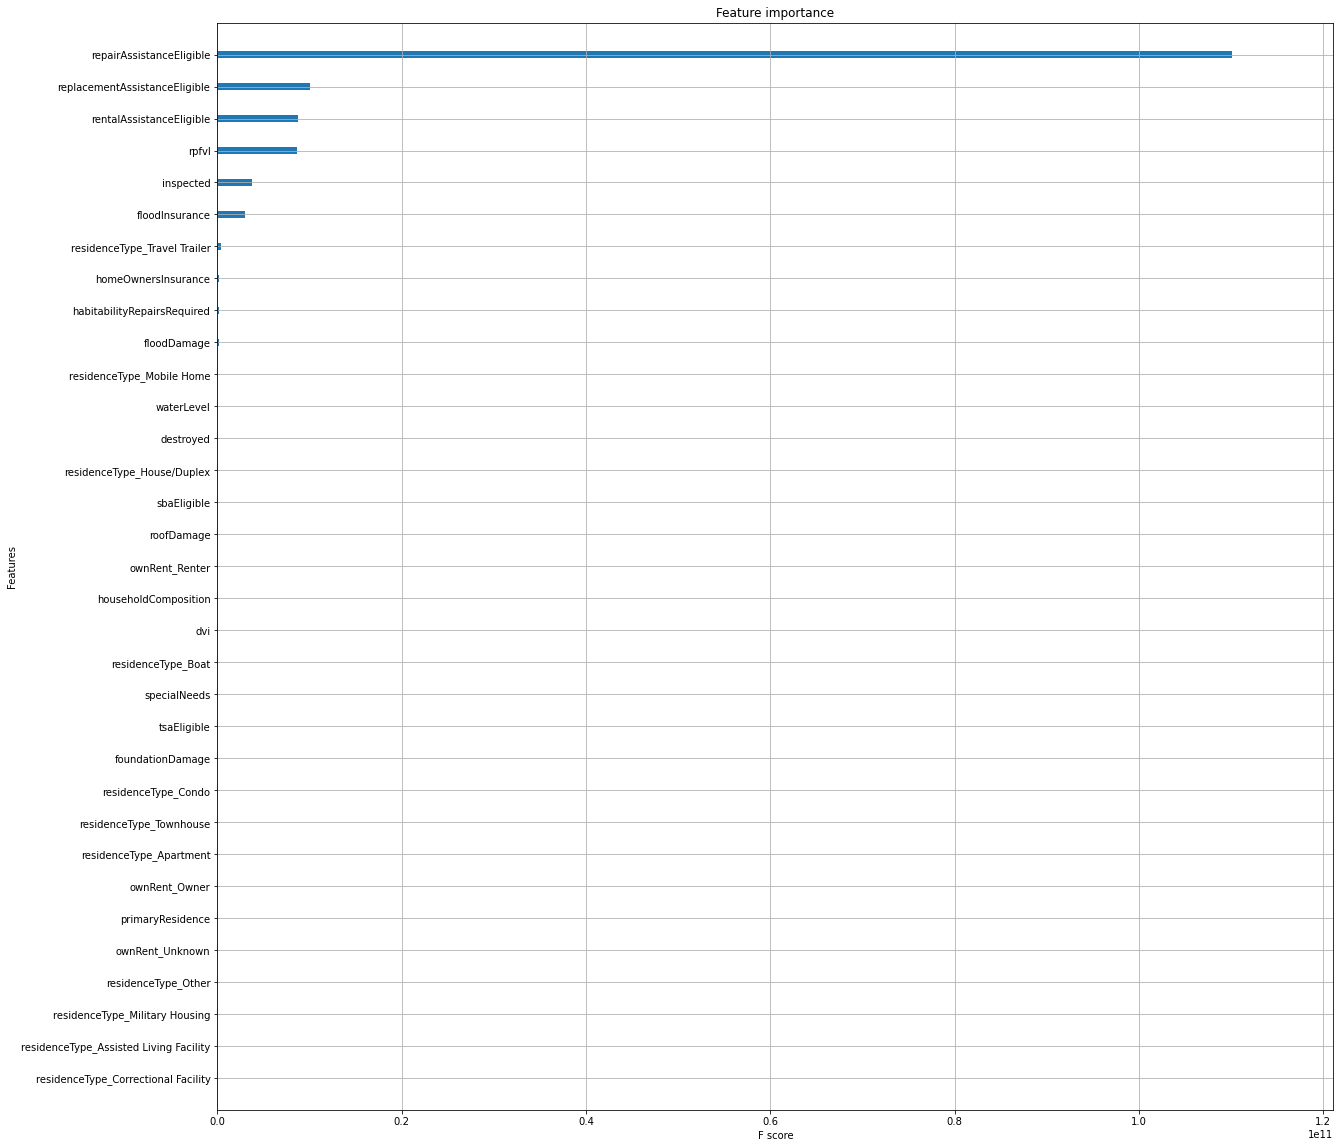

In [113]:
plot_importance(model_xgb_best, importance_type='gain', show_values = False)
plt.rcParams['figure.figsize'] = [20, 20]
plt.show()

In [115]:
# Save the model
pickle.dump(model_xgb_best, open('xgb_boost_dvi.sav', 'wb'))

In [116]:
# Load saved model
model_xgb_sav = pickle.load(open('xgb_boost.sav', 'rb'))
model_xgb_sav.get_params()

{'objective': 'reg:squarederror',
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'gpu_id': -1,
 'importance_type': 'gain',
 'interaction_constraints': '',
 'learning_rate': 0.05,
 'max_delta_step': 0,
 'max_depth': 10,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 8,
 'num_parallel_tree': 1,
 'random_state': 42,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 0.9,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

### GridSearch - IHP only, and min_child_weight

In [7]:
femaDf = femaTrainData[femaTrainData.columns[~femaTrainData.columns.isin(
    ihp_exclude_cols + demo_exclude_cols + demo_dvi_col + demo_rate_cols)]]

In [13]:
model_xgb_best, y_pred, y_test = run_xgb_grid_search(femaDf, 1.0)

Shape of Training and Test inputs
(2826930, 34) (2826930,)
(706733, 34) (706733,)
Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best params:
 {'learning_rate': 0.05, 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.8}


In [14]:
evaluate(y_test, y_pred)

Mean Absolute Error: 72.10994298388155
Mean Squared Error: 292981.8393460768
Root Mean Squared Error: 541.2779686501907
R-squared: 0.9534047890076546


Total HA Amount actual:    $385,808,834.81
Total HA Amount predicted: $383,712,256.00


Percentage of predictions that are off by more than 20%: 4.40


#### Variable Importance using Shapley (works best with smaller depth trees)

https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d

In [ ]:
shap_values = shap.TreeExplainer(model_xgb_best).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

In [ ]:
shap.summary_plot(shap_values, X_train)